In [1]:
import sys; sys.path.append("..")
from critical_ai_2026 import *


In [2]:
from hashstash import HashStash
import pandas as pd
from tqdm import tqdm
STASH_EMO_ANNO = HashStash(os.path.abspath("../data/emogens"))
STASH_EMO_ANNO

Config,Param,Value
Path,Root Dir,/Users/ryan/github/critical-ai-2026/data/emogens
,Filename,data.db
Engine,Engine,lmdb
,Serializer,hashstash
,Compress,lz4
,B64,True
Stats,Len,52


In [67]:
PATH_EMOSYS = os.path.abspath("../data/emotion_classifications.json")
EMOSYS_OK = [
    # "Plutchik 1980",
    "Parrott 2001",
    "Robinson 2009",
]

def get_emosys_options(emosys_ok = EMOSYS_OK):
    df = pd.read_json("../data/emotion_classifications.json")
    lines=[]
    emosys2options = {}
    gby = ["emotion_system_name", "emotion_system_year"]
    for (emosysname, emosysyear), gdf in df.groupby(gby):
        emosys = f'{emosysname} {emosysyear}'
        if emosys not in emosys_ok:
            continue
        opts = {}
        for emocat, ggdf in gdf.groupby("emotion_category"):
            emowords = list(ggdf.emotion_word.unique())[:100]
            opts[emocat] = emowords
        
        if len(opts) > 2:
            emosys2options[emosys] = opts

    return emosys2options


In [68]:


def emosys2prompt(emocat2words):
    system_prompt = """Read the following passage and choose which emotion categories
are represented in (depicted in, evoked by, etc) the passage.

Here are the categories from which you must choose and the 
words associated with them:

Return your answer in a JSON dictionary. The keys are the 
categories that you have chosen (each string must be the exact 
match of the category chosen), and their values are lists of strings
matching the relevant phrases from the passage that you used as
evidence for the category assignment.
"""
    lines = system_prompt.split("\n")
    for emocat, words in emocat2words.items():
        lines.append(f"* {emocat.upper()} ({', '.join(words)})")
    return "\n".join(lines)



In [69]:
emosys2options = get_emosys_options()
len(emosys2options)

2

In [71]:
def annotate_emotions(passage, model=DEFAULT_MODEL, verbose=True, **kwargs):
    dbkey = (passage,model)
    if dbkey in STASH_EMO_ANNO:
        out = STASH_EMO_ANNO[dbkey]
    else:
        out = {}
        for emosys,emocat2words in tqdm(emosys2options.items(), total=len(emosys2options), desc="Prompting for emotion annotations",disable=not verbose):
            prompt = emosys2prompt(emocat2words)
            data = generate_json(passage, system_prompt=prompt, model=model, max_tokens=1_000, verbose=False)
            if data:
                out[emosys] = data
        
        STASH_EMO_ANNO[dbkey] = out
    
    out2 = []

    def add(sysname, catname, egs):
        for eg in egs:
            out2.append({
                "emosys":sysname,
                "emocat":catname,
                "eg":eg,
            })
    
    for emosys, emocat2words in out.items():
        for emocat, words in emocat2words.items():
            if isinstance(words, dict):
                for emocat2, words2 in words.items():
                    add(emosys, f"{emocat} > {emocat2}", words2)
            else:
                add(emosys, emocat, words)
    odf = pd.DataFrame(out2)
    odf = odf[odf.emosys.isin(EMOSYS_OK)]
    return odf

In [72]:
# annotate_emotions(story)

In [73]:
df_poems = pd.read_csv("/Users/ryan/github/generative-formalism/data/data_as_in_paper/corpus_sample_by_period.csv.gz")
df_gen_poems = pd.read_csv("/Users/ryan/github/generative-formalism/data/data_as_in_paper/genai_rhyme_promptings.csv.gz")
df_gen_completions = pd.read_csv("/Users/ryan/github/generative-formalism/data/data_as_in_paper/genai_rhyme_completions.csv.gz")

In [137]:
smpl_len = 100
df_poems_smpl = df_poems.iloc[:smpl_len]
df_poems_smpl["century"] = (df_poems_smpl.year.astype(int) // 100 * 100).astype(str) + "s"
df_gen_poems_smpl = df_gen_poems.iloc[:smpl_len]
smpl_poem_txt = df_poems_smpl.txt.tolist()[0]
smpl_gen_poem_txt = df_gen_poems_smpl.txt.tolist()[0]

df_smpl = pd.concat([df_poems_smpl.assign(source="human", period_or_prompt=df_poems_smpl.century), df_gen_poems_smpl.assign(source="genai", period_or_prompt=df_gen_poems_smpl.prompt_type)])
df_smpl['txt_trunc'] = df_smpl.txt.apply(lambda x: truncate_text(x, 100))

In [138]:
# annotate_emotions("Hello bright and sunny day!")

In [139]:
def annotate_emotion_mp(poem_txts, model=DEFAULT_MODEL, verbose=False, n_workers=None):
    """Annotate emotions for multiple poems in parallel using a thread pool."""
    from concurrent.futures import ThreadPoolExecutor, as_completed

    if n_workers is None:
        n_workers = min(4, len(poem_txts))

    results = [None] * len(poem_txts)

    def _annotate(idx_txt):
        idx, txt = idx_txt
        return idx, annotate_emotions(txt, model=model, verbose=False)

    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        futures = {executor.submit(_annotate, (i, txt)): i for i, txt in enumerate(poem_txts)}
        for future in tqdm(as_completed(futures), total=len(poem_txts), desc="Annotating poems", disable=not verbose):
            idx, df = future.result()
            results[idx] = df.assign(txt_trunc=poem_txts[idx])

    return pd.concat(results).reset_index(drop=True)

In [140]:
odf = annotate_emotion_mp(df_smpl.txt_trunc.tolist(), model=DEFAULT_MODEL, verbose=True, n_workers=None)
# odf

Annotating poems:   0%|          | 0/200 [00:00<?, ?it/s]

Annotating poems:  74%|███████▍  | 149/200 [01:36<00:43,  1.17it/s]

Error parsing JSON: Expecting ',' delimiter: line 12 column 24 (char 407)


Annotating poems: 100%|██████████| 200/200 [02:22<00:00,  1.40it/s]


In [174]:
def get_stats(odf, df_smpl, include_period_or_prompt=True, max_cats=None):
    odf2 = odf.merge(df_smpl, on="txt_trunc", how="left").fillna("")
    gby = ["source","emosys","emocat"]
    gby2 = ["source"]
    if include_period_or_prompt:
        gby2.append("period_or_prompt")
        gby.append("period_or_prompt")
    dfstat = odf2.groupby(gby).agg({"eg": "count"})
    dfstat["perc"] = dfstat.eg / dfstat.groupby(gby2).eg.transform("sum")

    figdf = dfstat.reset_index()
    figdf["emo"] = figdf.emocat + " (" + figdf.emosys + ")"
    if include_period_or_prompt:
        figdf["group"] = figdf.source + " (" + figdf.period_or_prompt + ")"
    else:
        figdf["group"] = figdf.source

    cats = figdf.groupby("emo").perc.sum().sort_values(ascending=True).index.tolist()
    if max_cats is not None:
        cats = cats[:max_cats]
        figdf = figdf[figdf.emo.isin(cats)]
    figdf["emo"] = pd.Categorical(figdf.emo, categories=cats)
    figdf["perc_str"] = figdf.perc.apply(lambda x: f"{round(x*100,1)}%")
    return figdf
    

In [177]:
figdf = get_stats(odf, df_smpl, include_period_or_prompt=False, max_cats=10)
figdf

,source,emosys,emocat,eg,perc,emo,group,perc_str
1,genai,Parrott 2001,COURAGE,3,0.001573,COURAGE (Parrott 2001),genai,0.2%
6,genai,Parrott 2001,SURPRISE,35,0.018353,SURPRISE (Parrott 2001),genai,1.8%
9,genai,Robinson 2009,NEGATIVE - RELATED TO OBJECT PROPERTIES,11,0.005768,NEGATIVE - RELATED TO OBJECT PROPERTIES (Robin...,genai,0.6%
10,genai,Robinson 2009,NEGATIVE - SELF-APPRAISAL,7,0.003671,NEGATIVE - SELF-APPRAISAL (Robinson 2009),genai,0.4%
11,genai,Robinson 2009,NEGATIVE - SOCIAL,3,0.001573,NEGATIVE - SOCIAL (Robinson 2009),genai,0.2%
16,genai,Robinson 2009,POSITIVE - SELF-APPRAISAL,36,0.018878,POSITIVE - SELF-APPRAISAL (Robinson 2009),genai,1.9%
20,human,Parrott 2001,HOPE,6,0.002972,HOPE (Parrott 2001),human,0.3%
22,human,Parrott 2001,LONGING,3,0.001486,LONGING (Parrott 2001),human,0.1%
24,human,Parrott 2001,PRIDE,3,0.001486,PRIDE (Parrott 2001),human,0.1%
26,human,Parrott 2001,SURPRISE,24,0.011887,SURPRISE (Parrott 2001),human,1.2%


In [178]:
# !pip install scikit-misc

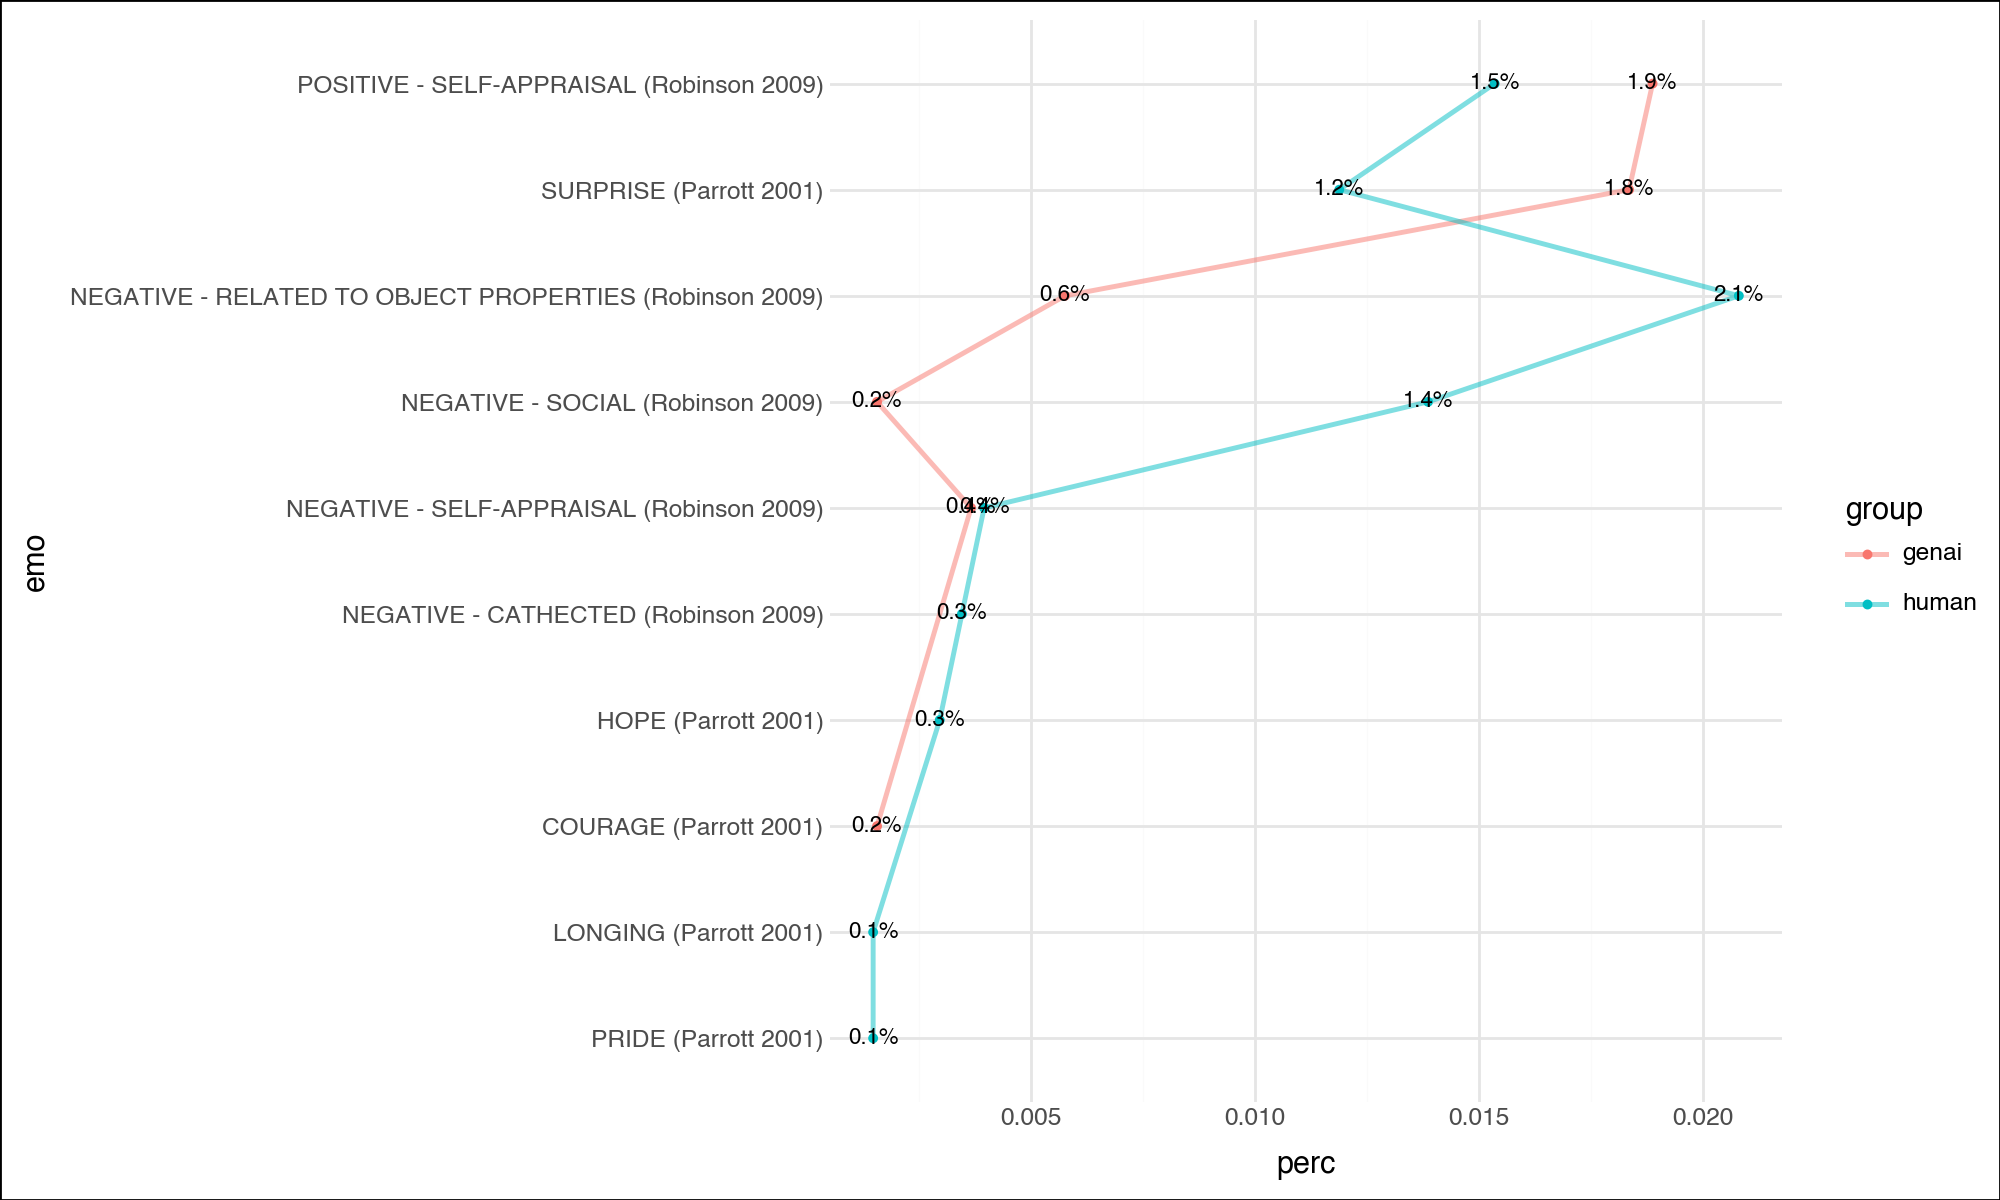

In [ ]:
import plotnine as p9
p9.options.figure_size = (10, 6)
fig = (
    p9.ggplot(figdf, p9.aes(x="emo", y="perc")) 
    + p9.geom_point(p9.aes(color="group"), size=1) 
    + p9.geom_line(p9.aes(group="group", color="group", linetype="source"), size=1, alpha=.5)
    # + p9.geom_smooth(p9.aes(linetype="source", group="source"), method="loess", span=0.5, se=False, size=.8)
    + p9.coord_flip()
    + p9.geom_text(p9.aes(label="perc_str"), size=8, color="black") 
    + p9.theme_minimal()
    + p9.theme(
        plot_background=p9.element_rect(fill="white"),
        panel_background=p9.element_rect(fill="white"),
    )
    # + p9.theme(legend_position="bottom")
)
fig
